# Running a ReCom Chain on Connecticut
* Set Up the chain
* @author Blayde Omura and Lisa Jurca
* AI for Redistricting final project on Connecticut

In [1]:
from gerrychain.random import random
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar
random.seed(12345678)

Create a directory that stores files for analysis

In [2]:
outdir="./CT_recom"

Here are parameters that we can change later if needed

In [3]:
total_steps_in_run=2000
save_district_graph_mod=1
save_district_plot_mod=100 # save every hundreth map

Import the graph 

In [4]:
os.makedirs(outdir, exist_ok=True)
ct_df = gpd.read_file("./CT/CT.shp")

print(ct_df.columns)

graph = Graph.from_geodataframe(ct_df)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSDBLU', 'G16USSRCAR',
       'G16USSLLIO', 'G16USSGRUS', 'G16USSOWRI', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'CD', 'geometry'],
      dtype='object')


These are the elections we have available:

In [5]:
elections = [
    Election("SEN16", {"Democratic": "G16USSDBLU", "Republican": "G16USSRCAR"}),
    Election("PRES16", {"Democratic": "G16PREDCLI", "Republican": "G16PRERTRU"})
]

"TOT_POP" is the population column from our shapefile

In [6]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")} # updaters, need to keep total population

Election updaters, for computing election results using the vote totals from our shapefile.

In [7]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

Create the partition

In [8]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "CD", 
                                        updaters=my_updaters)

The ReCom proposal needs to know the ideal population for the districts so that we can improve speed by bailing early on unbalanced partitions.

In [9]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition) # total pop / num districts

Create a proposal

In [10]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,  # can change to 5%
                   node_repeats=2
                  )

In [11]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [12]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

Create the markov chain

In [13]:
chain = MarkovChain( # markov chain
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps_in_run
    )

## Marginal Box Plots Democratic Senate 16 Election

In [14]:
# data frame that keeps track of percent democratic and sort it
data = pd.DataFrame(
    sorted(partition["SEN16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

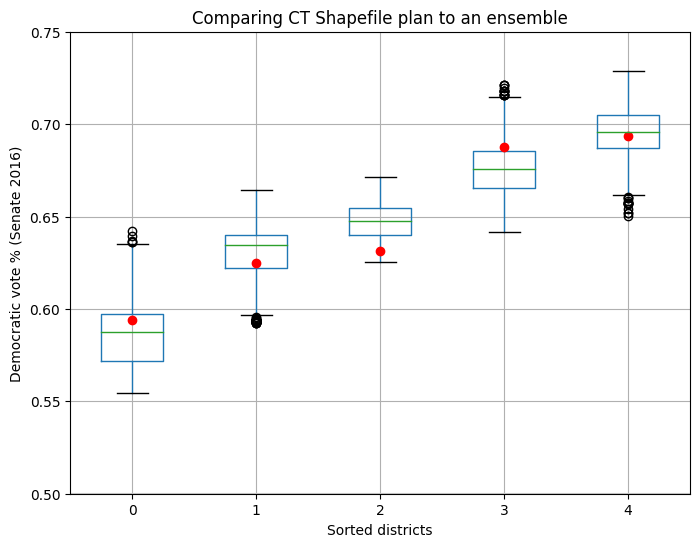

In [15]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(.50, .75)
ax.set_yticks([0.5, 0.55, 0.60, 0.65, 0.7, 0.75])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Republicans Senate 16 Election

In [16]:
# data frame that keeps track of percent democratic and sort it
data_rep_uss = pd.DataFrame(
    sorted(partition["SEN16"].percents("Republican"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

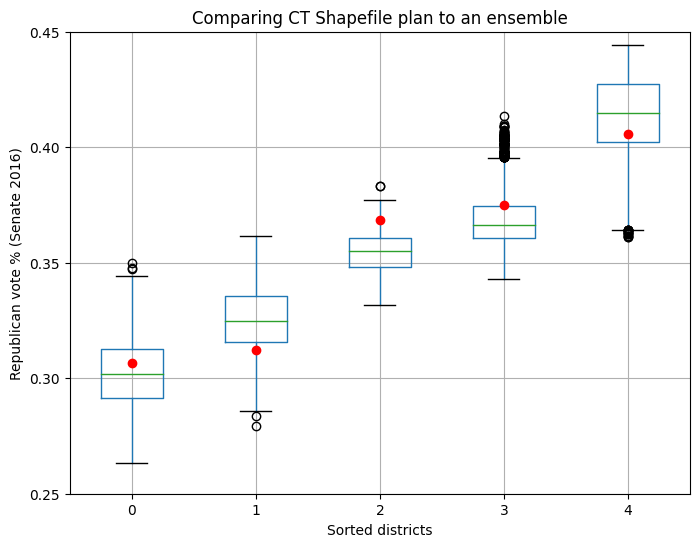

In [17]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_rep_uss.boxplot(ax=ax, positions=range(len(data_rep_uss.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_rep_uss.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Republican vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, .45)
ax.set_yticks([0.25, 0.3, 0.35, 0.4, 0.45])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Demcratcs Presidential 16 Election

In [18]:
# data frame that keeps track of percent democratic and sort it
data_dem_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

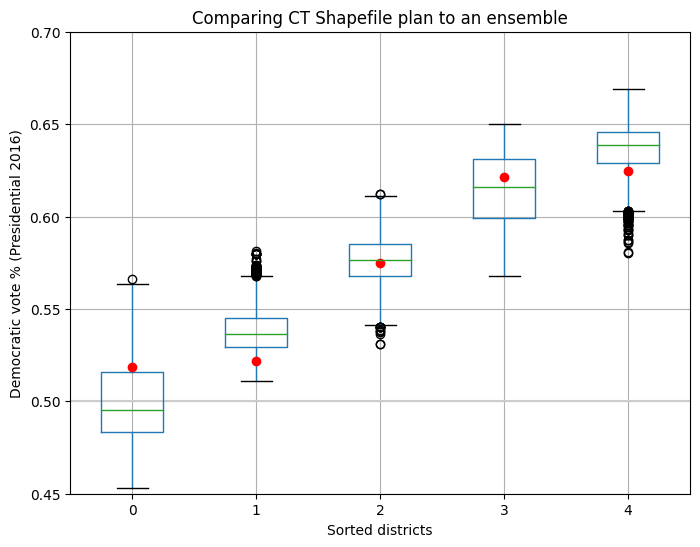

In [19]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_dem_pres.boxplot(ax=ax, positions=range(len(data_dem_pres.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_dem_pres.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Democratic vote % (Presidential 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.45, .7)
ax.set_yticks([0.45, 0.5, 0.55, 0.6, 0.65, 0.7])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Democrats Presidential 16 Election

In [20]:
# data frame that keeps track of percent democratic and sort it
data_rep_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Republican"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

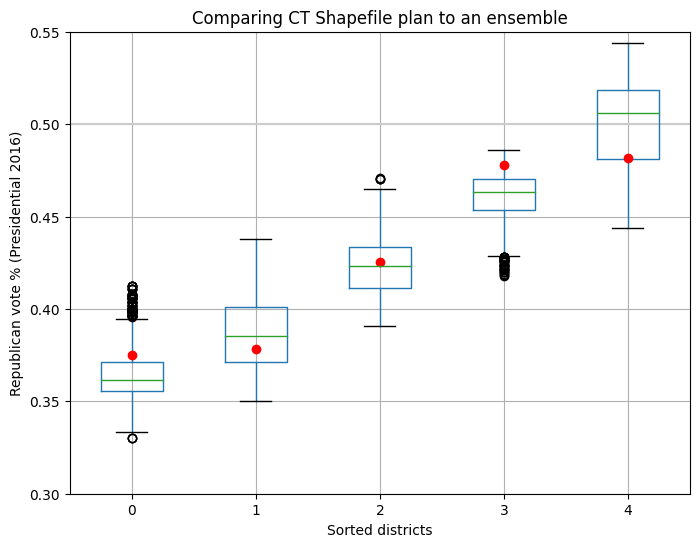

In [21]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_rep_pres.boxplot(ax=ax, positions=range(len(data_rep_pres.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_rep_pres.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Republican vote % (Presidential 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.3, 0.55)
ax.set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

# Outlier Analysis

### Run our random walk to be able to create histograms

In [22]:
pres_egaps = []
sen_egaps = []
pres_mmd = []
sen_mmd = []
cutedge_ensemble = []

for partition in chain:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(partition["cut_edges"]))

    # Storing efficiency gap metrics
    pres_egaps.append(partition["PRES16"].efficiency_gap())
    sen_egaps.append(partition["SEN16"].efficiency_gap())

    # Storing mean median metrics
    pres_mmd.append(partition["PRES16"].mean_median())
    sen_mmd.append(partition["SEN16"].mean_median())

## Efficiency Gap 

### Plot the Presidential histogram

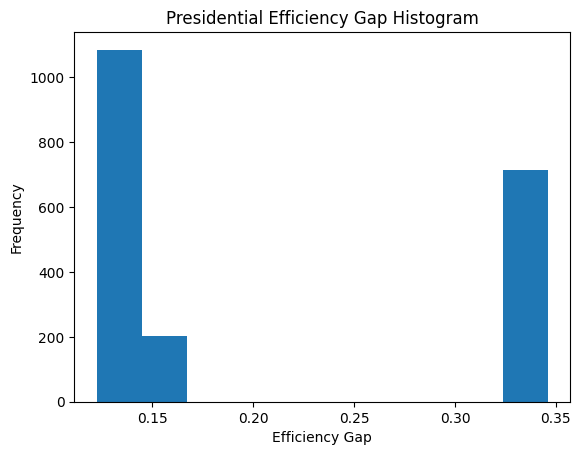

In [23]:
plt.figure()
plt.hist(pres_egaps, align = 'left')
plt.title('Presidential Efficiency Gap Histogram')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')
plt.show()

In [24]:
pres_eff_gap = initial_partition["PRES16"].efficiency_gap()
print(f"Presidential Efficiency Gap: {pres_eff_gap}")

Presidential Efficiency Gap: 0.35716904965472723


### Plot the Senate Histogram and Calculate Efficiency gap

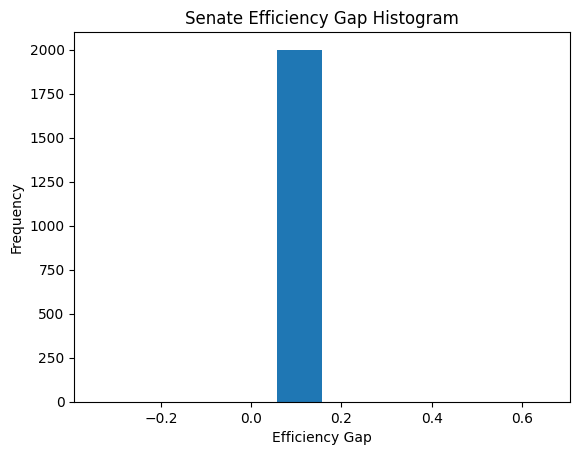

In [25]:
plt.figure()
plt.hist(sen_egaps, align = 'left')
plt.title('Senate Efficiency Gap Histogram')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')
plt.show()

In [26]:
sen_eff_gap = initial_partition["SEN16"].efficiency_gap()
print(f"Senate Efficiency Gap: {sen_eff_gap}")

Senate Efficiency Gap: 0.20788267732421292


# Mean Median Difference

### Plot Presidential Mean Median Difference

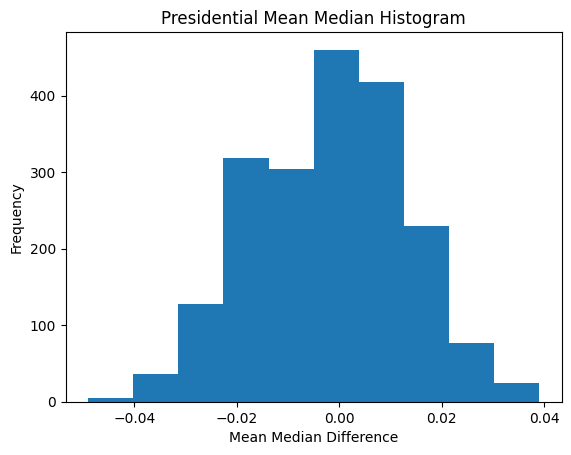

In [27]:
plt.figure()
plt.hist(pres_mmd, align = 'left')
plt.title('Presidential Mean Median Histogram')
plt.xlabel('Mean Median Difference')
plt.ylabel('Frequency')
plt.show()

In [28]:
pres_mean_median_diff = initial_partition["PRES16"].mean_median()
print(f"Presidential Mean-Median Difference: {pres_mean_median_diff}")

Presidential Mean-Median Difference: 0.0025703346431988905


### Senate Mean Median Difference

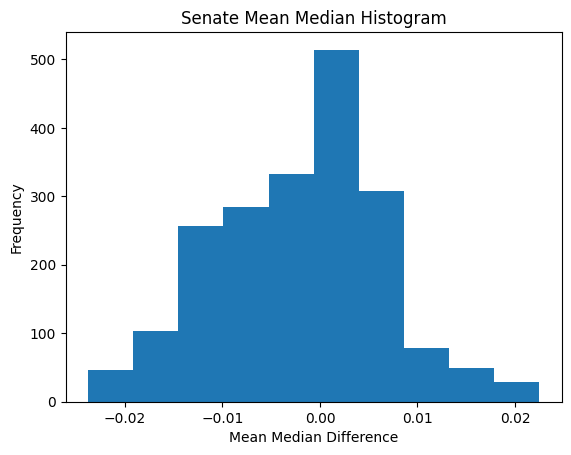

In [29]:
plt.figure()
plt.hist(sen_mmd, align = 'left')
plt.title('Senate Mean Median Histogram')
plt.xlabel('Mean Median Difference')
plt.ylabel('Frequency')
plt.show()

In [30]:
sen_mean_median_diff = initial_partition["SEN16"].mean_median()
print(f"Senate Mean-Median Difference: {sen_mean_median_diff}")

Senate Mean-Median Difference: -0.014978682744356098


# Democratic vs Republican Won Districts

## Dem vs Rep Won Districts: Presidential

In [31]:
# The ElectionResults object for "PRES16"
pres_election_results = initial_partition["PRES16"]

# Use the wins method to get the number of districts won by each party
pres_dem_won_districts = pres_election_results.wins("Democratic")
pres_rep_won_districts = pres_election_results.wins("Republican")

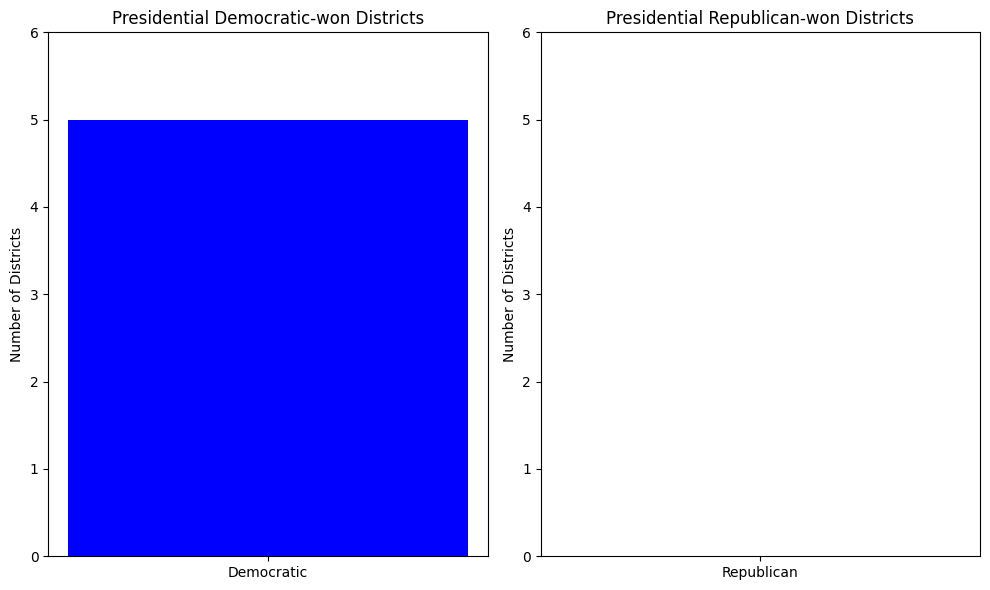

In [32]:
# Set up the figure and axes for two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # ncols=2 for two side-by-side plots

# Plot Democratic-won districts
axes[0].bar('Democratic', pres_dem_won_districts, color='blue')
axes[0].set_title('Presidential Democratic-won Districts')
axes[0].set_ylabel('Number of Districts')
axes[0].set_ylim(0, max(pres_dem_won_districts, pres_rep_won_districts) + 1)  # Set y limit to max won districts + 1 for spacing

# Plot Republican-won districts
axes[1].bar('Republican', pres_rep_won_districts, color='red')
axes[1].set_title('Presidential Republican-won Districts')
axes[1].set_ylabel('Number of Districts')
axes[1].set_ylim(0, max(pres_dem_won_districts, pres_rep_won_districts) + 1)  # Set y limit to max won districts + 1 for spacing

# Adjust the layout so that the plots are spaced nicely
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
# Presidential wins
print(f"Presidential Democratic-won Districts: {pres_dem_won_districts}")
print(f"Presidential Republican-won Districts: {pres_rep_won_districts}")

Presidential Democratic-won Districts: 5
Presidential Republican-won Districts: 0


## Dem vs Rep Won Districts: Senate

In [34]:
# The ElectionResults object for "SEN16"
sen_election_results = initial_partition["SEN16"]

# Use the wins method to get the number of districts won by each party
sen_dem_won_districts = sen_election_results.wins("Democratic")
sen_rep_won_districts = sen_election_results.wins("Republican")

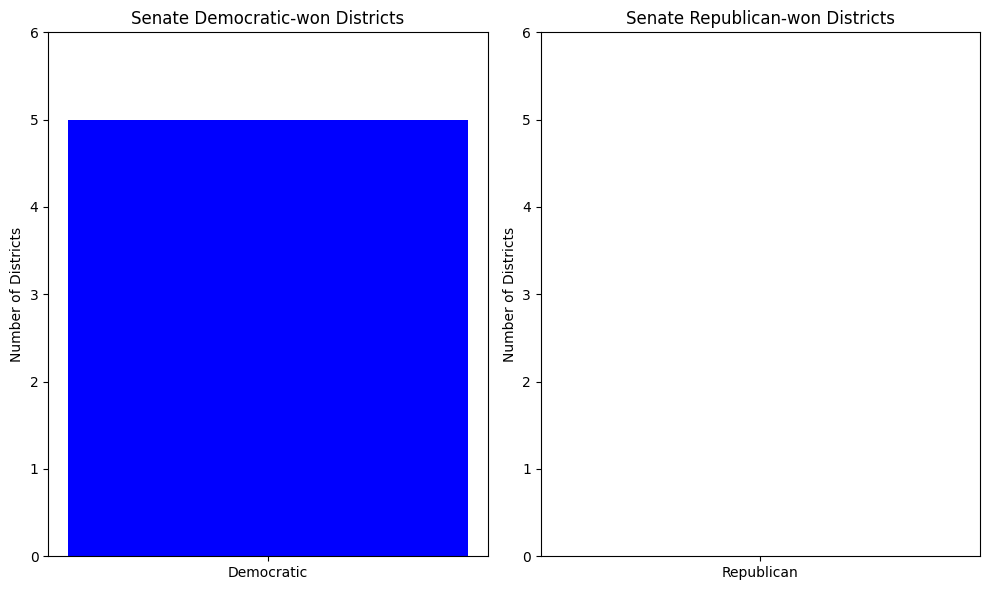

In [35]:
# Set up the figure and axes for two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # ncols=2 for two side-by-side plots

# Plot Democratic-won districts
axes[0].bar('Democratic', sen_dem_won_districts, color='blue')
axes[0].set_title('Senate Democratic-won Districts')
axes[0].set_ylabel('Number of Districts')
axes[0].set_ylim(0, max(sen_dem_won_districts, sen_rep_won_districts) + 1)  # Set y limit to max won districts + 1 for spacing

# Plot Republican-won districts
axes[1].bar('Republican', sen_rep_won_districts, color='red')
axes[1].set_title('Senate Republican-won Districts')
axes[1].set_ylabel('Number of Districts')
axes[1].set_ylim(0, max(sen_dem_won_districts, sen_rep_won_districts) + 1)  # Set y limit to max won districts + 1 for spacing

# Adjust the layout so that the plots are spaced nicely
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Print out the counts
print(f"Senate Democratic-won Districts: {sen_dem_won_districts}")
print(f"Senate Republican-won Districts: {sen_rep_won_districts}")

Senate Democratic-won Districts: 5
Senate Republican-won Districts: 0


# Cut Edges Histogram and Calculation

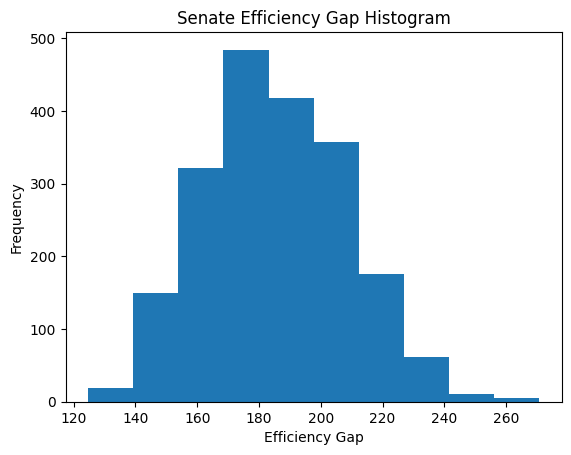

In [37]:
plt.figure()
plt.hist(cutedge_ensemble, align = 'left')
plt.title('Senate Efficiency Gap Histogram')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Cut edges can be accessed from the partition object
number_of_cut_edges = len(initial_partition["cut_edges"])

print(f"Number of cut edges: {number_of_cut_edges}")

Number of cut edges: 206
